In [1]:
import numpy as np
from New_functions import *
from Benchmark_functions import *
import warnings
import matplotlib.pyplot as plt
import time
warnings.filterwarnings("ignore")

In [2]:
'''
First, we generate a dataset, we can change the Alpha_s, Alpha_t and effect parameter to change the distribution of
the generated dataset.
'''

import numpy as np

def generate_binary(ns, nt, p, q, s, t, u, Alpha_s=1, Alpha_t=0, effect=1, x_effect=0, z_diff=0.1, threshold_X=0.5, threshold_Y=0.5):
    # Generate normal distributions for Z
    Zs_null = np.random.normal(0, 1, (ns, q))
    Zt_null = np.random.normal(0, 1, (nt, q))
    
    # Generate Z variables with and without shift
    Z_source = np.hstack((np.random.normal(0, 1, (ns, p)), Zs_null))
    Z_target = np.hstack((np.random.normal(z_diff, 1, (nt, p)), Zt_null))
    
    # Generate X variables
    X_source = Z_source[:, :p] @ u + np.random.normal(0, 1, ns)
    X_target = Z_target[:, :p] @ u + np.random.normal(0, 1, nt)
    
    # Convert X to binary
    X_source = (np.random.rand(ns) < 1 / (1 + np.exp(-X_source))).astype(int)
    X_target = (np.random.rand(nt) < 1 / (1 + np.exp(-X_target))).astype(int)
    
    # Generate V variables
    V_source = Z_source[:, :p] @ s + Alpha_s * X_source + np.random.normal(0, 5, ns)
    V_target = Z_target[:, :p] @ t + Alpha_t * X_target + np.random.normal(0, 5, nt)
    
    # Generate Y variables
    Y_source = (Z_source[:, :p].sum(axis=1))**2 + effect * V_source + np.random.normal(0, 1, ns) + x_effect * X_source
    Y_target = (Z_target[:, :p].sum(axis=1))**2 + effect * V_target + np.random.normal(0, 1, nt) + x_effect * X_target
    
    # Convert Y to binary
    Y_source = (np.random.rand(ns) < 1 / (1 + np.exp(-Y_source))).astype(int)
    Y_target = (np.random.rand(nt) < 1 / (1 + np.exp(-Y_target))).astype(int)
    
    return Y_source.reshape(-1, 1), X_source.reshape(-1, 1), V_source.reshape(-1, 1), Z_source,\
           Y_target.reshape(-1, 1), X_target.reshape(-1, 1), V_target.reshape(-1, 1), Z_target



def generate(ns, nt, p,q, s, t, u, Alpha_s=0, Alpha_t = 2,effect=1,x_effect = 0, non_lin = 0, z_diff = 0.1):
    Zs_null = np.random.normal(0,0.1, (ns, q))
    Zt_null = np.random.normal(0,0.1, (nt, q))
    
    Z_source = np.hstack((np.random.normal(0, 1, (ns, p)) , Zs_null))
    Z_target = np.hstack((np.random.normal(z_diff, 1, (nt, p)) , Zt_null))
    
    X_source = Z_source[:, :p] @ u + np.random.normal(0, 1, ns)
    X_target = Z_target[:, :p] @ u + np.random.normal(0, 1, nt)

    V_source = Z_source[:, :p] @ s + (1-non_lin)*Alpha_s * X_source + non_lin * Alpha_s * np.sin(X_source) + np.random.normal(0, 5, ns)
    V_target = Z_target[:, :p] @ t + (1-non_lin)*Alpha_t * X_target + non_lin * Alpha_t * np.sin(X_target) + np.random.normal(0, 5, nt)
    
    # V_source = Z_source[:, :p] @ s + 2*X_source 
    # V_target = Z_target[:, :p] @ t - 2*X_target
    
    Y_source = (Z_source[:, :p].sum(axis=1))**2 + effect*V_source + x_effect*X_source + np.random.normal(0, 1, ns) 
    Y_target = (Z_target[:, :p].sum(axis=1))**2 + effect*V_target + x_effect*X_target +np.random.normal(0, 1, nt) 
    
    
    return Y_source.reshape(-1, 1), X_source.reshape(-1, 1), V_source.reshape(-1, 1), Z_source,\
           Y_target.reshape(-1, 1), X_target.reshape(-1, 1), V_target.reshape(-1, 1), Z_target

In [26]:
#Set parameter for the generation of data
ns, p,q = 1000, 5, 50
nt = 2000

s = np.array([-1, -0.5, 0, 1, 1.5])
t = np.array([ 1, -1, 0.5 , -0.5, -1])
u = np.array([ 0, -1, 0.5, -0.5, 1])

Y_source, X_source, V_source, Z_source,Y_target, X_target, V_target, Z_target = \
generate(ns,nt, p,q, s, t, u, Alpha_s=0, Alpha_t = 2,effect=1, z_diff = 0.1)
            

In [27]:
# Data Separation:
# The data arrays X_e, Z_e, V_e are designated for density ratio estimation.
# The arrays Z_source, X_source, V_source, Y_source are used for testing.
# Here, we split the source data based on a specified proportion.

proportion = 0.5
num = int(proportion * X_source.shape[0])
Z_e = Z_source[:num]
X_e = X_source[:num]
V_e = V_source[:num]
Z_source = Z_source[num+1:]
X_source = X_source[num+1:]
V_source = V_source[num+1:]
Y_source = Y_source[num+1:]


# Real data experiments to run

## Our method

In [28]:
#1. Test without power enhancement
Test(X_e, Z_e, V_e, X_source, Z_source, V_source, Y_source, \
     X_target, Z_target, V_target, L=3, K=20, datatype='continuous')


2.3758900175059643


0.30143409093787754

In [13]:
#2. Test with power enhancement

Test_pe(X_e, Z_e, V_e, X_source, Z_source, V_source, Y_source, \
        X_target, Z_target, V_target, L=3, K=20, datatype='continuous')

[0.47165802 0.691986   0.58597947]


0.007195709829017516

### Use a different scoring function for testing V for the Power enhancement

In [17]:
# Originally, we use v*x for scoring, here we use (-v)*x to detect 
# the negative correlation between Y and V
Test_pe(X_e, Z_e, V_e, X_source, Z_source, V_source, Y_source, \
        X_target, Z_target, V_target, L=3, K=20, datatype='binary', score = 'neg')

[-0.24195826  0.22223624 -0.23156712]


0.11639344900462212

## Benchmark
there are 3 benchmarks:1. Use source only data, 2. Use target only data, 3. Importance sampling method (the benchmark from others)

In [28]:
#1. Use source data only
#2. Test with power enhancement

PCR_test(X_source,Z_source,V_source,Y_source)


0.6250775742972228

In [29]:
#2. Use target data only

PCR_test(X_target,Z_target,V_target,Y_target)

0.40498554498650197

In [7]:
#3. Use Importance Sampling benchmark method

IS_test(X_e, Z_e, V_e, X_source, Z_source, V_source, Y_source, X_target, Z_target, V_target, L=3, K=20, datatype='continuous')


0.78052570104495

## Tune hyperparameter L

In [9]:
l_lst = [2, 5, 8, 10]
result_lst = []
for l in l_lst:
    # Use any test function above
    pvalue = Test_pe(X_e, Z_e, V_e, X_source, Z_source, V_source, Y_source, X_target, Z_target, V_target, L=3, K=20, datatype='binary')
    result_lst.append(pvalue)
    print(f'L is {l}, pvalue: {pvalue}')

Training accuracy for X|Z: 0.717
[0.23433064 0.19167032 0.28155873]
[167.95443516 165.08707733 174.75729811]
L is 2, pvalue: 0.933563916771966
Training accuracy for X|Z: 0.717
[0.2952632  0.20613484 0.31138347]
[140.64749537 187.91719237 174.08845475]
L is 5, pvalue: 0.06342484042790109
Training accuracy for X|Z: 0.717
[0.2715509  0.20274784 0.29688373]
[148.2607481  172.03479922 184.74858996]
L is 8, pvalue: 0.21636110362760874
Training accuracy for X|Z: 0.717
[0.29121139 0.13614264 0.34778643]
[146.78635223 166.57257311 184.67772408]
L is 10, pvalue: 0.195118444312963


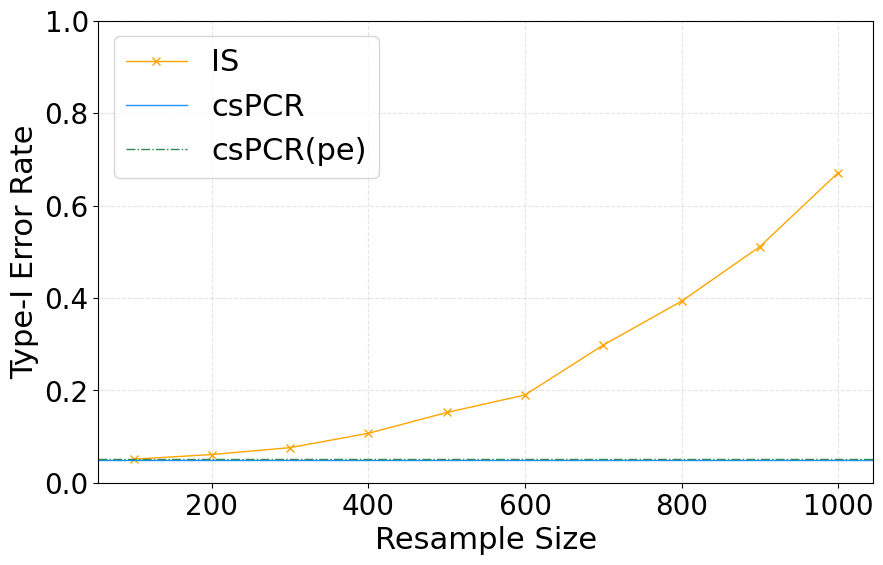

In [37]:
import matplotlib.pyplot as plt

# Manually input the new data
M_values = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
size_values = [0.051, 0.061, 0.076, 0.107, 0.152, 0.19, 0.298, 0.393, 0.511, 0.671]

# Create a stylish plot
plt.figure(figsize=(10, 6))  # Set figure size

# Plot the data
plt.plot(M_values, size_values, marker='x', linestyle='-', color='orange',
         linewidth=1, markersize=6, label='IS')

# Add labels and title
plt.xlabel('Resample Size', fontsize=22)  # X-axis label with fontsize
plt.ylabel('Type-I Error Rate', fontsize=22)  # Y-axis label with fontsize
plt.ylim(0, 1)  # Adjust y-axis limits if necessary
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Optional: Horizontal line to show the threshold of interest
plt.axhline(y = 0.049, color = 'dodgerblue', linestyle = '-', linewidth=1, alpha = 1, label = 'csPCR')
plt.axhline(y = 0.051, color = 'seagreen', linestyle = '-.', linewidth=1, alpha = 1, label = 'csPCR(pe)')

plt.legend(fontsize=22)  # Add a legend
plt.grid(True, linestyle='--', color='grey', alpha=0.2)  # Add grid lines # Save as a high-resolution image
plt.show()  # Display the plot

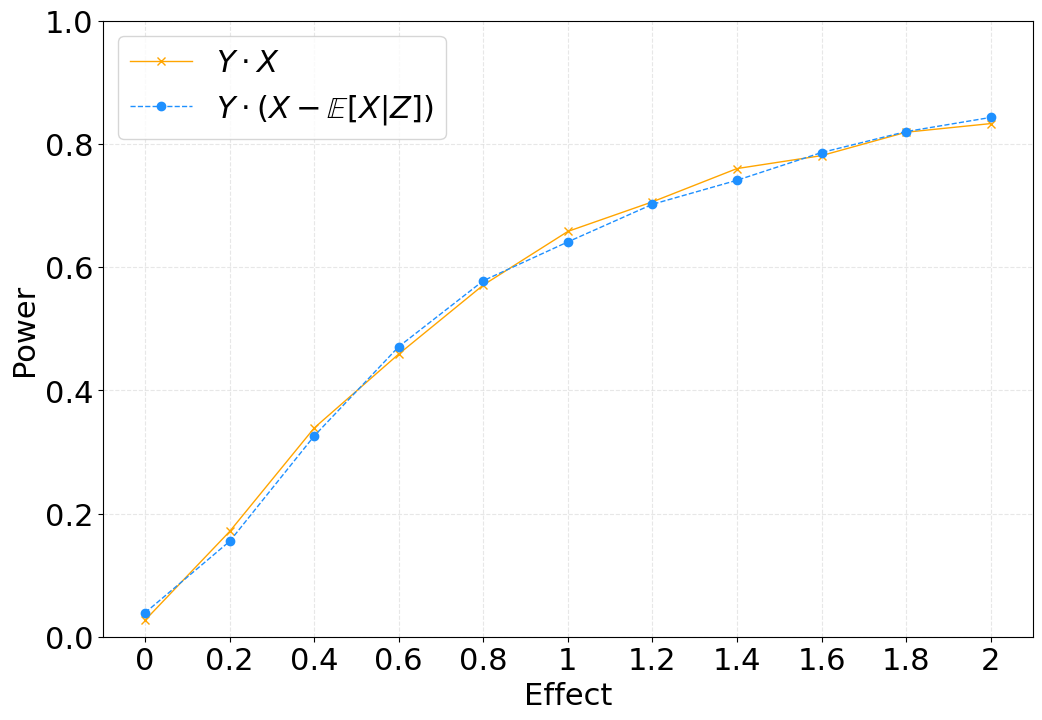

In [26]:
import matplotlib.pyplot as plt

# Data for each method
data = {
    r'$Y \cdot X$': {'1': 0.658, '0.4': 0.339, '2': 0.833, '1.4': 0.76, '1.8': 0.819, '0.2': 0.171, '0.8': 0.571, '1.6': 0.781, '1.2': 0.706, '0.6': 0.459, '0': 0.027},
    r'$Y \cdot (X - \mathbb{E}[X|Z])$': {'1.4': 0.741, '1.6': 0.786, '0.6': 0.471, '1.2': 0.702, '0.4': 0.326, '0.8': 0.578, '1.8': 0.82, '0.2': 0.155, '2': 0.843, '0': 0.039, '1': 0.641}}

colors = {r'$Y \cdot X$': 'orange', r'$Y \cdot (X - \mathbb{E}[X|Z])$': 'dodgerblue'}
markers = {r'$Y \cdot X$': 'x', r'$Y \cdot (X - \mathbb{E}[X|Z])$': 'o'}
linestyles = {r'$Y \cdot X$': '-', r'$Y \cdot (X - \mathbb{E}[X|Z])$': '--'}

# Create a figure
plt.figure(figsize=(12, 8))

# Plot data for each method
for method, details in data.items():
    # Sorting the data by sample size (convert keys to int for accurate sorting)
    sorted_samples = sorted(details.items(), key=lambda x: float(x[0]))
    samples = [sample for sample, value in sorted_samples]
    sizes = [value for sample, value in sorted_samples]

    # Plotting
    plt.plot(samples, sizes, linestyle=linestyles[method], color=colors[method],
             marker=markers[method], linewidth=1, markersize=6, label=method)

# Add labels and title
plt.xlabel('Effect', fontsize=22)
plt.ylabel('Power', fontsize=22)
plt.ylim(0, 1) 
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=22)
plt.grid(True, linestyle='--', alpha=0.3)

# Show the plot
plt.show()
